# Examples for the KernelDensityBoundaries1D class

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from KDEBoundaries1D import KernelDensityBoundaries1D
from sklearn.model_selection import validation_curve
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KernelDensity
from kde import KernelDensityMod
from scipy.stats import norm
%matplotlib inline

### First case: classical gaussian without any boundaries

BW silverman:  0.264904861125092


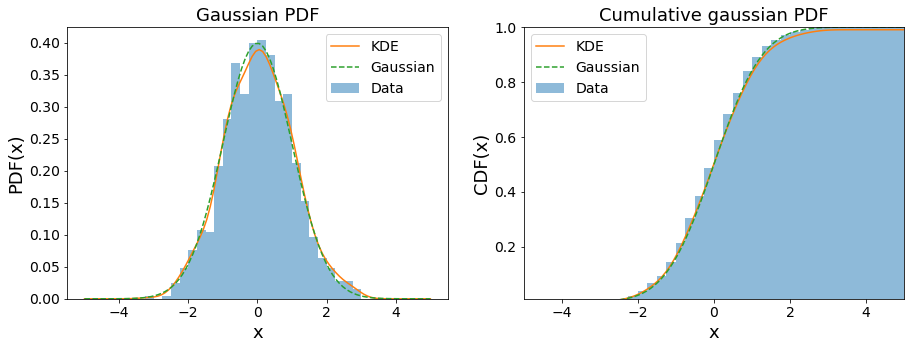

In [2]:
random = np.random.randn(1000)

bw_silverman = np.std(random)*np.power(4/(3*len(random)), 1./5)
print("BW silverman: ", bw_silverman)
kde_gauss_nobound = KernelDensityBoundaries1D(bandwidth=bw_silverman)
kde_gauss_nobound.fit(random[:, np.newaxis])


Nbins = 40
xrange = [-5, 5]
xminmax = xrange[1]-xrange[0]
plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)

plt.hist(random, bins=Nbins, range=xrange, density=True, label="Data",
        alpha=0.5)

Xvalues = np.linspace(-5, 5, 100)
plt.plot(Xvalues,
         np.array(kde_gauss_nobound.score_samples(Xvalues[:, np.newaxis])),
         label = "KDE")
plt.plot(Xvalues, norm.pdf(Xvalues), label="Gaussian", linestyle="--")
plt.ylabel("PDF(x)", fontsize=18)
plt.xlabel("x", fontsize=18)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.title("Gaussian PDF", fontsize=18)
plt.legend(fontsize=14)


plt.subplot(1, 2, 2)

plt.hist(random, bins=Nbins, range=xrange, cumulative=True, density=True,
        alpha=0.5, label="Data")
yvalues = np.array(kde_gauss_nobound.score_samples(Xvalues[:, np.newaxis]))\
        .cumsum()*10/100

#yvalues = yvalues/yvalues[len(yvalues)-1]

plt.plot(Xvalues, yvalues, label="KDE")
plt.plot(Xvalues, norm.cdf(Xvalues), linestyle="--", label="Gaussian")
plt.xlim([-5, 5])
plt.ylim([1e-2, 1])
plt.ylabel("CDF(x)", fontsize=18)
plt.xlabel("x", fontsize=18)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
#plt.yscale("log")
plt.title("Cumulative gaussian PDF", fontsize=18)
plt.legend(fontsize=14)

### Compatibility with sk-learn classes (Grid search, validation curve...)

Like the KernelDensity class, you can use the grid search, validation curve, etc functions/classes from sklearn to obtain the optimal bandwith

In [3]:
KDEtoOptimise = KernelDensityBoundaries1D()

range_values = [0.01, 0.05, 0.1, 0.2, 0.3, 0.5, 1, 2, 5, 10]
grid = GridSearchCV(KDEtoOptimise, {'bandwidth': range_values})
grid.fit(random[:,np.newaxis])
print("best bandwidth: {0}".format(grid.best_estimator_.bandwidth))


tr_score, tst_score = validation_curve(estimator=KDEtoOptimise,
                                       X=random[:, np.newaxis],
                                       y=None,
                                       cv=5, param_name="bandwidth",
                                       param_range=range_values)

best bandwidth: 0.3


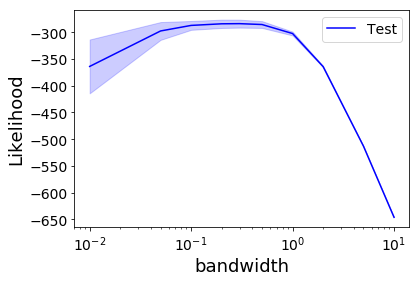

In [4]:
mean_tr = np.mean(tr_score, axis=1)
std_tr = np.std(tr_score, axis=1)
mean_tst = np.mean(tst_score, axis=1)
std_tst = np.std(tst_score, axis=1)
#plt.plot(range_values, mean_tr, color="red", label="Training")
#plt.fill_between(range_values,
#                 mean_tr - std_tr,
#                 mean_tr + std_tr,
#                 alpha=0.2, color="red")
plt.plot(range_values, mean_tst, color="blue", label="Test")
plt.fill_between(range_values,
                 mean_tst - std_tst,
                 mean_tst + std_tst,
                 alpha=0.2, color="blue")
plt.xscale("log")
plt.xlabel("bandwidth", fontsize=18)
plt.ylabel("Likelihood", fontsize=18)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.legend(fontsize=14)
plt.show()

### Second case: Boundary conditions (exponential)

We're going to apply a KDE to a distribution which is non-zero for a minimum value of x. 

In [5]:
values = np.random.exponential(5, 2000) + 5
cvsamp = 3

kdeCW = KernelDensityBoundaries1D(kernel="expo", boundary="CowlingHall",
                                     range=[5, 100])
kderef = KernelDensityBoundaries1D(kernel="expo", boundary="reflection",
                                     range=[5, 100])
kdenobound = KernelDensityBoundaries1D(kernel="expo", boundary=None,
                                     range=[5, 100])


range_values = [0.01, 0.05, 0.1, 0.2, 0.3, 0.5, 1, 2, 5, 10]
gridCW = GridSearchCV(kdeCW, {'bandwidth': range_values}, cv=cvsamp)
gridCW.fit(values[:, np.newaxis])
print("best bandwidth C&W: {0}".format(gridCW.best_estimator_.bandwidth))

gridref = GridSearchCV(kderef, {'bandwidth': range_values}, cv=cvsamp)
gridref.fit(values[:, np.newaxis])
print("best bandwidth ref: {0}".format(gridref.best_estimator_.bandwidth))

gridnobound = GridSearchCV(kdenobound, {'bandwidth': range_values}, cv=cvsamp)
gridnobound.fit(values[:, np.newaxis])
print("best bandwidth nobound: {0}".format(gridnobound.best_estimator_.bandwidth))

best bandwidth C&W: 0.5
best bandwidth ref: 1
best bandwidth nobound: 0.3


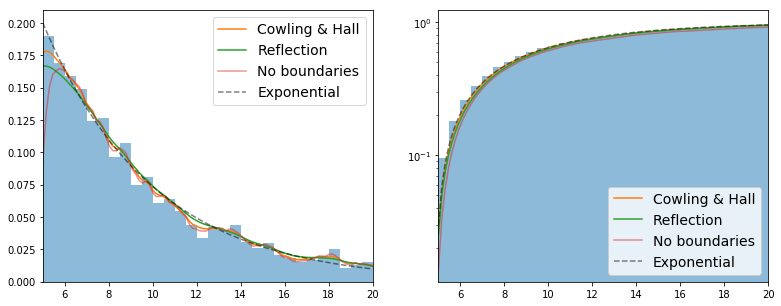

In [6]:
estimCW = gridCW.best_estimator_
estimref = gridref.best_estimator_
estimnobound = gridnobound.best_estimator_

xmin = 5
xmax = 20
npoints = 100
bwidth = (xmax-xmin)/npoints
Xvalues = np.linspace(xmin, xmax, npoints)


plt.figure(figsize=(13,5))

plt.subplot(1,2,1)
plt.hist(values, bins=70, range=[5, 40], density=True, alpha=0.5)
plt.plot(Xvalues, estimCW.score_samples(Xvalues[:, np.newaxis]), label="Cowling & Hall")
plt.plot(Xvalues, estimref.score_samples(Xvalues[:, np.newaxis]), label = "Reflection")
plt.plot(Xvalues, estimnobound.score_samples(Xvalues[:, np.newaxis]), label = "No boundaries",
         alpha=0.5)
plt.plot(Xvalues, (1/5)*np.exp(-(Xvalues-5)/5), linestyle="--", color="black",
         label="Exponential", alpha=0.5)
plt.xlim([5,20])
plt.legend(fontsize=14)

plt.subplot(1,2,2)
plt.hist(values, bins=70, range=[5, 40], density=True, alpha=0.5, cumulative=True)

plt.plot(Xvalues, np.array(estimCW.score_samples(Xvalues[:, np.newaxis])).cumsum()*bwidth,
         label="Cowling & Hall")
plt.plot(Xvalues, np.array(estimref.score_samples(Xvalues[:, np.newaxis])).cumsum()*bwidth, 
         label = "Reflection")
plt.plot(Xvalues, np.array(estimnobound.score_samples(Xvalues[:, np.newaxis])).cumsum()*bwidth,
         label = "No boundaries", alpha=0.5)
plt.plot(Xvalues, ((1/5)*np.exp(-(Xvalues-5)/5)).cumsum()*15/100, linestyle="--", color="black",
         label="Exponential", alpha=0.5)
plt.xlim([5,20])
plt.yscale("log")
plt.legend(fontsize=14, loc=4)

### Boundary conditions: region between two gaussians

Now we're going to do the same but for the distribution defined by a specific range of a custom PDF

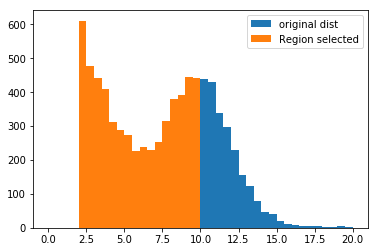

In [7]:
values1 = np.random.exponential(3,4000) + 2
values2 = np.random.randn(4000)*2 + 10
values = np.concatenate((values1, values2))

region = values[(values > 2) & (values < 10)]
plt.hist(values, range=[0, 20], bins=40, label="original dist")
plt.hist(region, range=[0,20], bins=40, label="Region selected")
plt.legend()
plt.show()

In [8]:
bw_silverman = np.std(region)*np.power(4/(3*len(region)), 1./5)

kderefl2 = KernelDensityBoundaries1D(kernel="gaussian", boundary="reflection",
                                      range=[2, 10], bandwidth=bw_silverman)

kderefl2.fit(region[:, np.newaxis])

#For some reason, the GridSearch fails miserably here!

KernelDensityBoundaries1D(bandwidth=0.48256144958973807,
             boundary='reflection', kernel='gaussian', n_approx=-1,
             range=[2, 10])

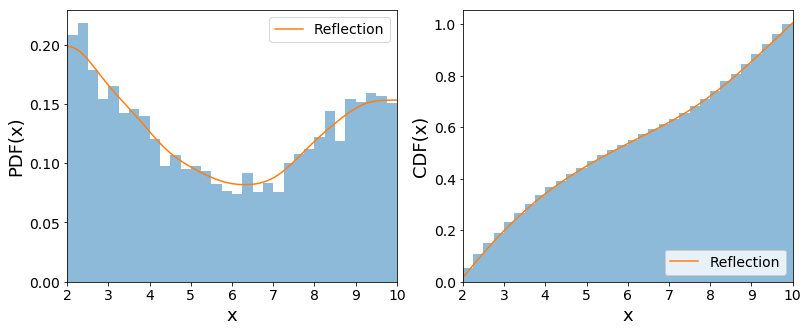

In [9]:

xmin = 2
xmax = 10
npoints = 100
bwidth = (xmax-xmin)/npoints
Xvalues = np.linspace(xmin, xmax, npoints)

plt.figure(figsize=(13,5))

plt.subplot(1,2,1)
plt.hist(region, bins=32, range=[2, 10], density=True, alpha=0.5)
plt.plot(Xvalues, kderefl2.score_samples(Xvalues[:, np.newaxis]), label = "Reflection")
plt.xlim([2,10])
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel("x", fontsize=18)
plt.ylabel("PDF(x)", fontsize=18)
plt.legend(fontsize=14)

plt.subplot(1,2,2)
plt.hist(region, bins=32, range=[2, 10], density=True, alpha=0.5, cumulative=True)

plt.plot(Xvalues, np.array(kderefl2.score_samples(Xvalues[:, np.newaxis])).cumsum()*bwidth, 
         label = "Reflection")

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel("x", fontsize=18)
plt.ylabel("CDF(x)", fontsize=18)

plt.xlim([2,10])
plt.legend(fontsize=14, loc=4)

### The KernelDensity and KernelDensityMod classes

In principle, you should be able to get the same output KDEs with the sklearn KernelDensity() class. Here I also test the KernelDensityMod() class.

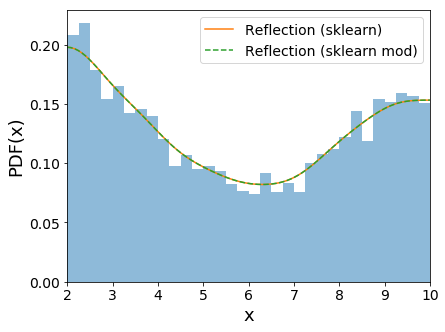

In [10]:
kde_sklearn = KernelDensity(kernel="gaussian", bandwidth=0.5)
kde_sklearn.fit(region[:, np.newaxis])

kde_sklearnmod = KernelDensityMod(kernel="gaussian", bandwidth=0.5, boundary="reflection",
                                  boundrange=[2,10])
kde_sklearnmod.fit(region[:, np.newaxis])

Xmin = 2
Xmax = 10

plt.figure(figsize=(6.5, 5))
plt.hist(region, bins=32, range=[2, 10], density=True, alpha=0.5)
plt.plot(Xvalues, np.exp(kde_sklearn.score_samples(Xvalues[:, np.newaxis]))
                 + np.exp(kde_sklearn.score_samples(2*Xmin - Xvalues[:, np.newaxis]))
                 + np.exp(kde_sklearn.score_samples(2*Xmax - Xvalues[:, np.newaxis])),
        label = "Reflection (sklearn)")

plt.plot(Xvalues, np.exp(kde_sklearnmod.score_samples(Xvalues[:, np.newaxis])),
        label = "Reflection (sklearn mod)", linestyle="--")


plt.xlim([2,10])
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel("x", fontsize=18)
plt.ylabel("PDF(x)", fontsize=18)
plt.legend(fontsize=14)

In [11]:
values = np.random.exponential(5, 3000) + 5
cvsamp = 3

kdeCW = KernelDensityMod(kernel="exponential", boundary="CowlingHall",
                                     boundrange=[5, 100], bandwidth = 0.5)

kdeCW.fit(values[:, np.newaxis])

kdeCWorg = KernelDensityBoundaries1D(kernel="expo", boundary="CowlingHall",
                                     range=[5, 100], bandwidth = 0.5)

kdeCWorg.fit(values[:, np.newaxis])

KernelDensityBoundaries1D(bandwidth=0.5, boundary='CowlingHall',
             kernel='expo', n_approx=-1, range=[5, 100])

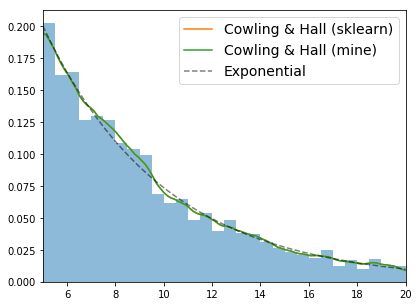

In [13]:
Xmin = 5
Xmax = 20
npoints = 100
Xvalues = np.linspace(Xmin, Xmax, npoints)

plt.figure(figsize=(6.5, 5))
plt.hist(values, bins=70, range=[5, 40], density=True, alpha=0.5)
plt.plot(Xvalues, np.exp(kdeCW.score_samples(Xvalues[:, np.newaxis])), label="Cowling & Hall (sklearn)")
plt.plot(Xvalues, kdeCWorg.score_samples(Xvalues[:, np.newaxis]), label = "Cowling & Hall (mine)")
plt.plot(Xvalues, (1/5)*np.exp(-(Xvalues-5)/5), linestyle="--", color="black",
         label="Exponential", alpha=0.5)
plt.xlim([5,20])
plt.legend(fontsize=14)